<a href="https://colab.research.google.com/github/christopher-ell/Deep_Learning_Begin/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb

**Algorithm Summary**

Data Prep


1.   Import content image and style image
2.   Transform both images into matrix of numbers
3. Make sure all matrixes only have 4 dimensions and each number representing a colour is within a range of numbers (+/-255) and
    has the correct mean




Model
4. Select layers from the middle of the VGG19 neural network, so they are not to early and identify too early shapes but also not too specific later
5. Run both style and content images through the selected layers to provide activation layers for each image

Content Loss
6. Calculate content loss by runnng content and target image activation layers through formula for content loss

Style Loss
7. Calculate gram matrix for target and style image activation function. This provides the correlations between different channels (and hence features) of the style image
8. Run the style and target gram matrixes through the loss formula to get the loss for that
9. Add the style and content losses together



In [0]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [4]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
# Set up some global values here
content_path = '/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'

# Visualize the input

In [0]:
## Open image and if it isn't the correct scale along any dimension find the 
## difference and scale length and width by it.

def load_img(path_to_img):
  ## Maximum dimension of image
  max_dim = 512
  ## Import image
  img = Image.open(path_to_img)
  ## take the longest dimension of the image
  long = max(img.size)
  ## Calculate how much image needs to be scaled to make longest dimension 512
  scale = max_dim/long
  ## Scale all sides of image by ratio to get the longest side to 512
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  ## Convert the image into an array of numbers that can be processed by the algorithm
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  ## Add extra dimension to image array
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  ## To show the image we need to remove the extra dimension we added in 
  ## load_img of expand_dims()
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  ## Not sure precisely what this does disabled and no effect
  out = out.astype('uint8')
  ## Show the image (Not sure what this show img does)
  plt.imshow(out)
  ## If a title is put into the function output that otherwise nothing
  if title is not None:
    plt.title(title)
  ## Show the image
  plt.imshow(out)

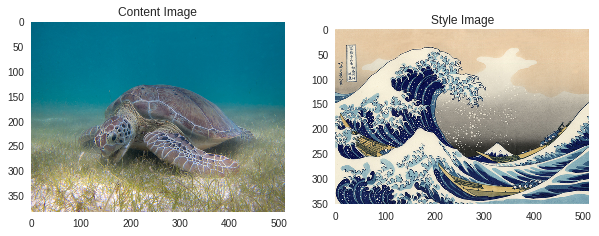

In [8]:
## Not sure exactly what this does taking off has no effect
plt.figure(figsize=(10,10))

## Load and store images 
## Not sure what unit8 does
content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

## Create place to store image
plt.subplot(1, 2, 1)
## Output image
imshow(content, 'Content Image')

## Create place to store image
plt.subplot(1, 2, 2)
## Output image
imshow(style, 'Style Image')

## Show images
plt.show()

# Prepare the data

In [0]:
def load_and_process_img(path_to_img):
  ## Load image and do some processing so it is correct dimensions and number 
  ## format
  img = load_img(path_to_img)
  ## Transform the image input into an input acceptable by the model
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
## Make sure image has correct dimensions and it numercial values are correctly
## normalised and clipped
def deprocess_img(processed_img):
  ## Create a copy of the image
  x = processed_img.copy()
  ## If there are more than 4 dimensions remove one
  if len(x.shape) == 4:
    ## Remove axis 0 of image
    x = np.squeeze(x, 0)
  ## Tell user why image requires three dimensions
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  ## Raise error if image doesn't have three dimensions
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  ## Normalise each channel by means of VGG network of [103.939, 116.779, 123.68]
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  
  ## Processed image can theoretically take any value between +/- infinity so 
  ## the extreme values are clipped between 0 and 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
## Select layers of vgg19 to use for content and style layers 
## Layers must not be too early as they are then to rudimentary and not to late
## as they are then too specific.

# Content layer which will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
## Runs the selected image through the selected contents and style layers to
## get the activation layers
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  ## Load VGG19 model with imagenet weights
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  ## Don't allow adjustment of weights
  ## In style transfer to reduce losses rather than adjusting the neural network
  ## you adjust the target image
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  ## Get style layers specified above
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  ## Get contents layers specified above
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  ## Add style and contents layers togeher
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [0]:
## Calculate the content loss of the base image with the target 
def get_content_loss(base_content, target):
  ## Formula for calculating contents loss
  return tf.reduce_mean(tf.square(base_content - target))

In [0]:
## Calculate gram matrix for style loss multiplying the activation layer by the
## inverse of itself
def gram_matrix(input_tensor):
  # We make the image channels first
  ## Work out how many layers (channels/filter) the activation layer has 
  channels = int(input_tensor.shape[-1])
  ## Reshape input tensor so each layer becomes single column in larger matrix
  ## Rows equal to number of layers
  ## columns equal to data points in each layer/channel/filter
  a = tf.reshape(input_tensor, [-1, channels])
  
  ## Returns number of rows in tensor, translating to number of layers
  n = tf.shape(a)[0]
  
  ## Multiplies matrix a by matrix a transposing the first matrix a
  gram = tf.matmul(a, a, transpose_a=True)
  ## Turns into floating point numbers (Not really sure why it divides) ???
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  ## Get dimensions of style matrix
  height, width, channels = base_style.get_shape().as_list()
  ## Create gram matrix (matrix multiplied by transpose of itself)
  gram_style = gram_matrix(base_style)
  
  ## Run result through style loss formula
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [0]:
## Load images run them through the model and extract activation functions into 
## lists
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  ## Load images and have them ready to feed into the model
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  ## Run both style and content images through the model for activation layers
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  ## Extract the different channel/layers/filters from the model and put them 
  ## into a list
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [0]:
## Compute he loss for each style and content layer and weigh it by inverse of 
## number of layers for style and inverse of number of layers for contents.
## Then weigh the style and contents losses by the selected weightings for them.
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  ## unpack the loss weightings for style and contents
  ## This tells the model how important style is relative to content
  ## In the default case here style weigh is 0.01 and content is 1000 so content
  ## is 10,000 times more important than style and so the losses for content
  ## are given 10,000 times more weight.
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  ## init_image is the target image we are modifying to create our have the same
  ## style as our style image and same content as our content image.
  ## Here we run it through our intermediate model layers to get its activation
  ## layers.
  model_outputs = model(init_image)
  
  ## unpack the style activation layers for the target image 
  style_output_features = model_outputs[:num_style_layers]
  ## unpack the content activation layers for the target image 
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  ## Since there is no reason to value one style layer over another they are 
  ## all given equal weight of the inverse of the total number
  weight_per_style_layer = 1.0 / float(num_style_layers)
  ## Loop through each layer/filter/chanel of both the style image activation
  ## layers and the target image activation layers 
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    ## Calculate the total loss between the style activation layers and the 
    ## target activation layers
    ## style image activations are input as gram matrix as they only need to be
    ## calculated once but gram matrix need to be recalculated each iteration 
    ## so are input as activation layers each time.
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

# Optimization loop

In [0]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss

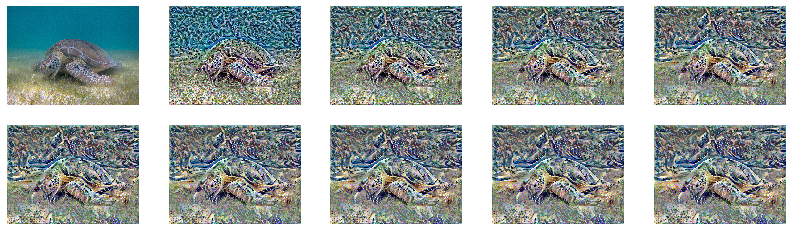

In [0]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

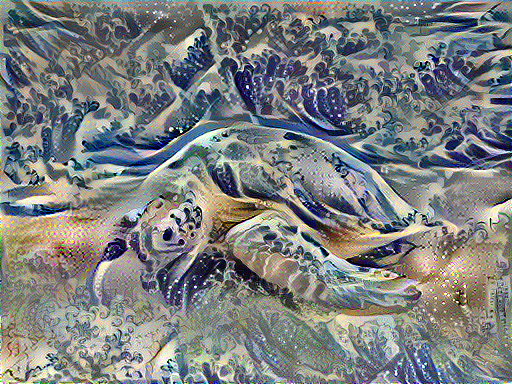

In [0]:
Image.fromarray(best)

In [0]:
#from google.colab import files
#files.download('wave_turtle.png')

# Visualize outputs

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

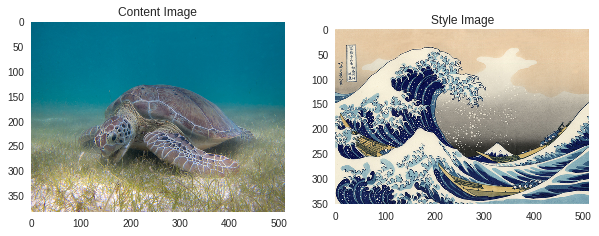

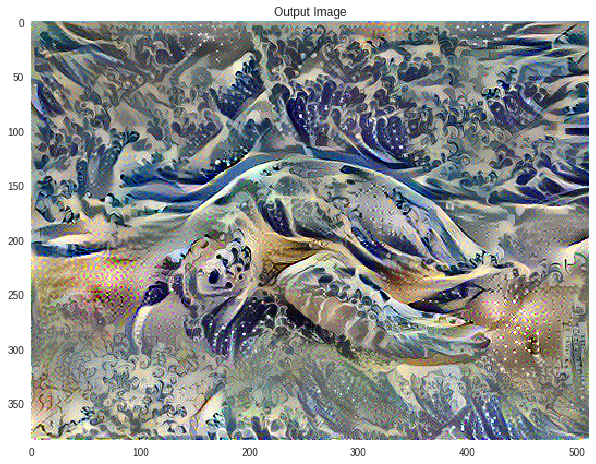

In [0]:
show_results(best, content_path, style_path)